# Advanced Lane Line Finding

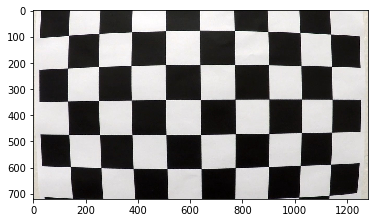

In [1]:
# import packages
import numpy as np
import cv2
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# read in sample calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

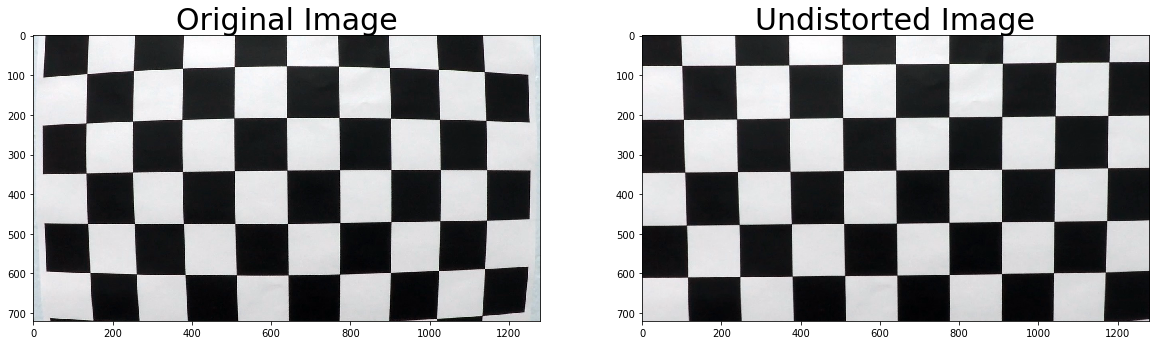

In [2]:
import glob
import pickle
import os.path
from tqdm import tqdm

sample_calibration_img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (sample_calibration_img.shape[1], sample_calibration_img.shape[0])

pickle_file_name = 'camera_distort_pickle.p'
if os.path.isfile(pickle_file_name):
    # load camera distortion matrix if already exists
    dist_pickle = pickle.load(open(pickle_file_name, 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
else:    
    nx = 9
    ny = 5
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    objpoints = []  # 3D coord in real world
    imgpoints = []  # 2D coord in image plane

    images = glob.glob('./camera_cal/calibration*.jpg')
    for file_path in tqdm(images):
        img = cv2.imread(file_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result for later use
    dist_pickle = {
        'mtx': mtx,
        'dist': dist,
    }
    pickle.dump(dist_pickle, open('camera_distort_pickle.p', 'wb'))

undist = cv2.undistort(sample_calibration_img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/test1_undist.jpg', undist)
    

# Visualize results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(sample_calibration_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
def s_magnitude(hls, thresh = (190, 255)):
    """Input the undistorted HLS image, filter 
    the S channel magnitude and returns a binary image
    """
    s_channel = hls[:,:,2]
    magnitude_binary = np.zeros_like(s_channel)
    magnitude_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return magnitude_binary  

def l_direction(hls):
    """Input a HLS color space image, filter the
    magnitude and direction sobel edge detection 
    and returns a binary image
    """
    l_channel = hls[:,:,1]
    sobel_kernel=9
    m_thresh=(40, 255)
    d_thresh=(0.6, 1.36)
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled = np.uint8(255*magnitude/np.max(magnitude))
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[
        (direction >= d_thresh[0])&
        (direction <= d_thresh[1])&
        (scaled >= m_thresh[0])&
        (scaled <= m_thresh[1])] = 1
    return binary_output

<function __main__.thresholding>

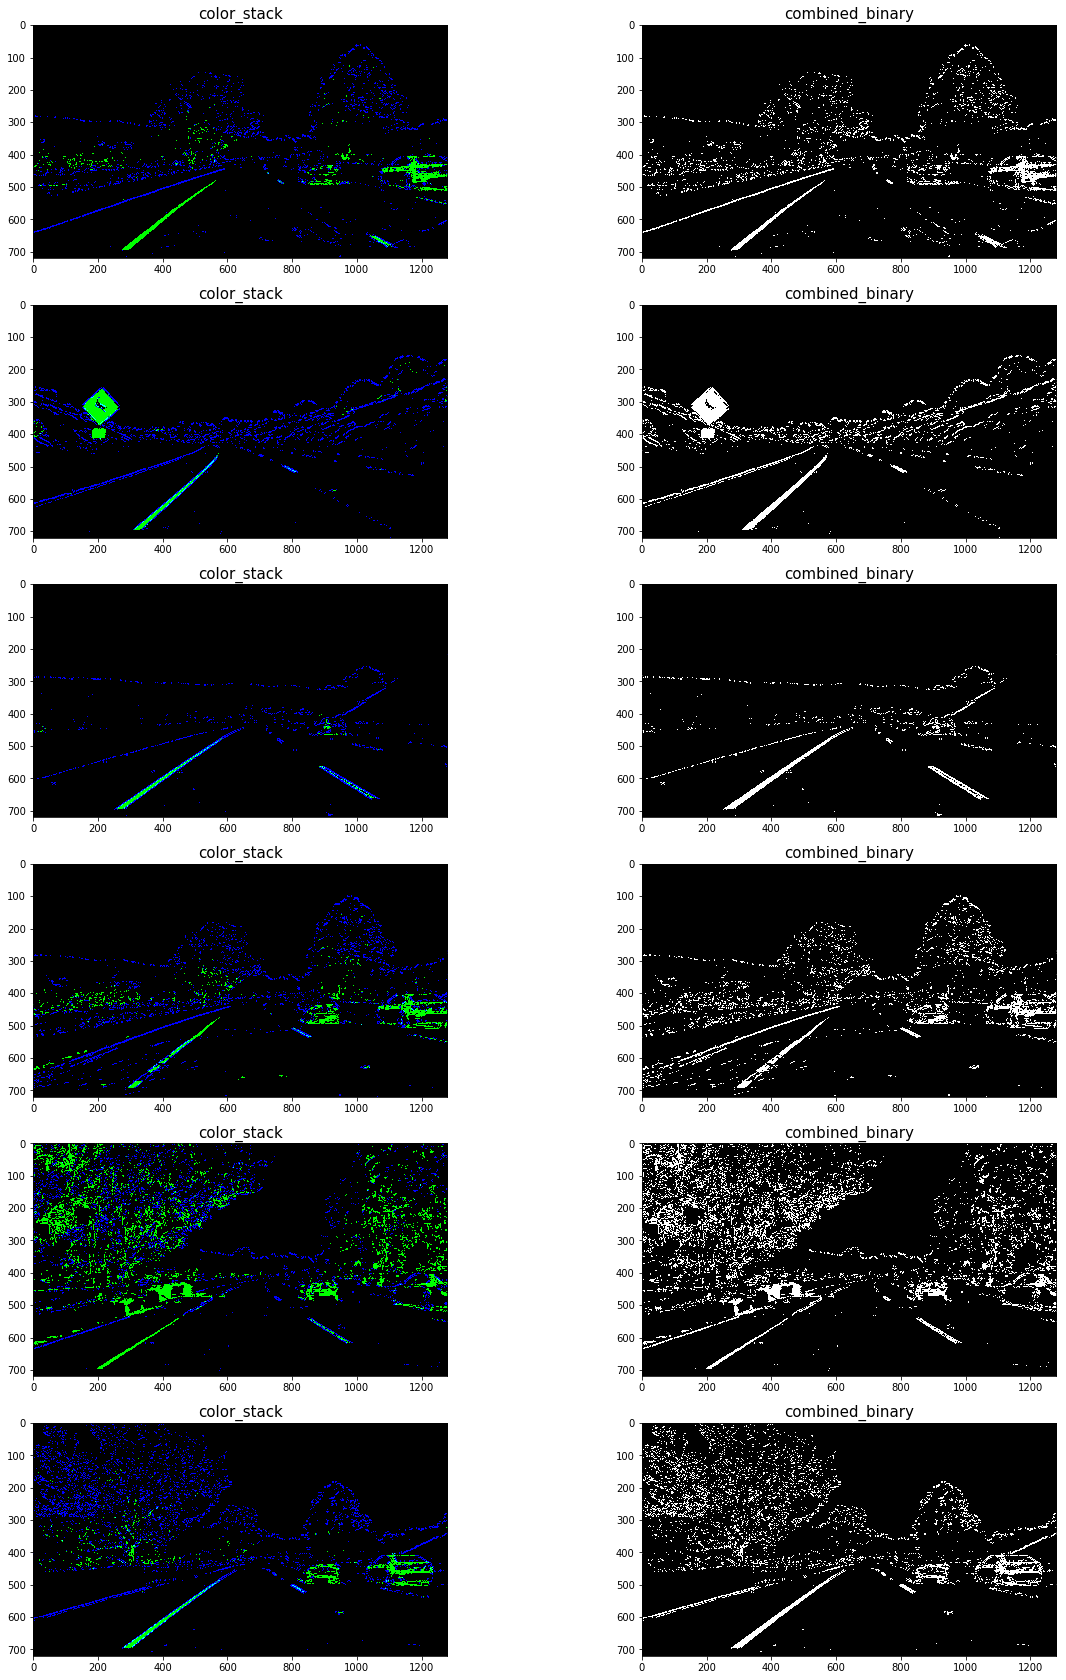

In [50]:
# Find good gradient parameters
from ipywidgets import interact, widgets

def thresholding():
    """View filter results on test images"""
    f, axarr = plt.subplots(6, 2, figsize=(20, 30))
    for i in range(6):
        img = cv2.imread('./test_images/test%d.jpg' % (i+1))
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
        # rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

        s_mag = s_magnitude(hls)
        l_dir = l_direction(hls)
        # stack s_mag as green color and l_dir as blue color
        color_stack = np.dstack(( np.zeros_like(s_mag), s_mag, l_dir))
        
        # combine 2 channels into single binary image
        combined_binary = np.zeros_like(s_mag)
        combined_binary[(s_mag == 1) | (l_dir == 1)] = 1
        
        # plot the result images
        axarr[i, 0].imshow(color_stack)
        axarr[i, 0].set_title('color_stack', fontsize=15)

        axarr[i, 1].imshow(combined_binary, cmap='gray')
        axarr[i, 1].set_title('combined_binary', fontsize=15)
        
interact(thresholding)

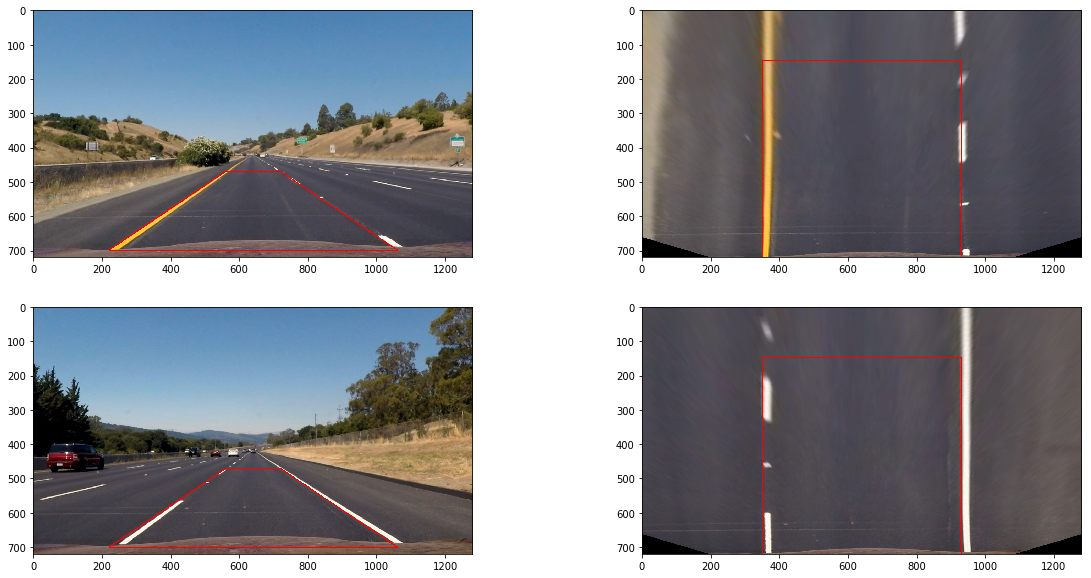

In [52]:
# Perspective transform
# TODO(Olala): get a function the simply returns the
# perspective transform matrix

def perspectiveTransform(img, draw_perspective=False):
    height, width, _ = img.shape
    tls = (562, 470)  # top left source point
    bls = (220, 700)   # bottom left source point
    src = np.float32([
        [tls[0], tls[1]],
        [width-tls[0], tls[1]],
        [width-bls[0], bls[1]],
        [bls[0], bls[1]],
    ])
    src.reshape((-1, 1, 2))
    
    tld = (350, 150)
    bld = (350, 720)
    dst = np.float32([
        [tld[0], tld[1]],
        [width-tld[0], tld[1]],
        [width-tld[0], bld[1]],
        [bld[0], bld[1]],
    ])
    transform_mtx = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(
        img, transform_mtx, (width, height), flags=cv2.INTER_LINEAR)
    if draw_perspective:
        # draw source point on originimage
        cv2.polylines(img, [src.astype(np.int32)], True, (255, 0, 0), thickness=2)
        # draw destination point on warped
        cv2.polylines(warped, [dst.astype(np.int32)], True, (255, 0, 0), thickness=2)
    
    return warped
    # return img

f, axarr = plt.subplots(2, 2, figsize=(20, 10))

for i in range(2):
    img = cv2.imread('./test_images/straight_lines%d.jpg' % (i+1))
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

    warped = perspectiveTransform(rgb, draw_perspective=True)
    axarr[i][0].imshow(rgb)
    axarr[i][1].imshow(warped)

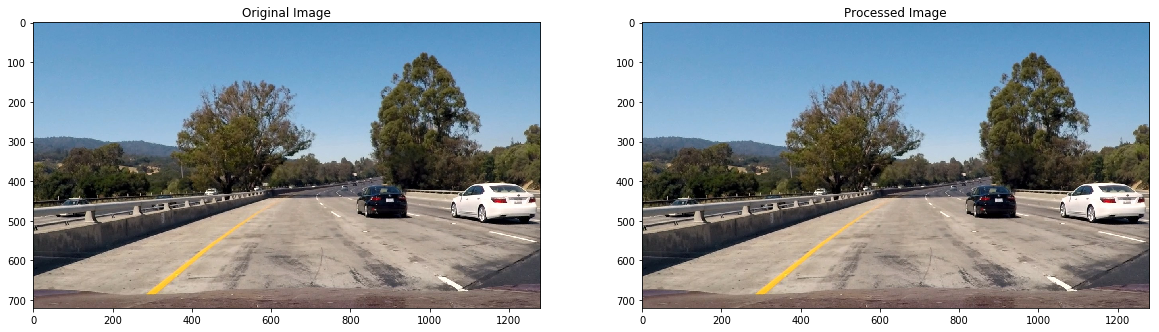

In [6]:
def image_pipeline(img):
    """Main pipeline that finds laneline"""
    img = np.copy(img)
    return img

test_images = glob.glob('./test_images/test*.jpg')
for img_path in test_images:
    orig_img_bgr = cv2.imread(img_path)
    orig_img = cv2.cvtColor(orig_img_bgr, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    processed_img = image_pipeline(orig_img)
    
    ax1.imshow(orig_img)
    ax1.set_title('Original Image')
    ax2.imshow(processed_img)
    ax2.set_title('Processed Image')
    plt.show()
    break  # TODO(Olala): remove this after pipeline implemented